# Fast Transient Searches

Borrows from materials created by Igor Andreoni (igor.andreoni@unc.edu) for the 2022 ZTF Summer School, and by Eric Bellm in the [Zwicky Transient Facility GitHub](https://github.com/ZwickyTransientFacility/ztf-avro-alert/blob/master/notebooks/Filtering_alerts.ipynb). 

Prepared by Anna Ho (annayqho@cornell.edu) for the LSST CCA Summer School 2025.

### Objective
The objective of this notebook is to search a night's worth of LSST-style alerts for short-duration extragalactic transients.

## Required python packages (pip install)
json, os, numpy, glob, io, pandas, matplotlib, fastavro, gzip, astropy, collections

## Ancillary datasets
ztf_partnership_20210116_random_subset.tar.gz

### Introduction
Wide-field surveys such as ATLAS, ASAS-SN, and ZTF image the entire observable sky approximately once per night. They also survey smaller areas multiple times per night, in order to be sensitive to shorter-duration phenomena. In ZTF's case, the area is about 10% of the sky, and the program is called the "high-cadence survey". LSST will do something similar in its "deep drilling fields." Image subtraction between a new "science" image and a deep "reference" (or "template") image makes every new source, or every source that changes in brightness, stand out. When such a source is identified in a new image, an alert packet is issued, which is a dictionary rich with information, including differential photometry between the science and the template images. LSST will use avro-style alerts, in exactly the same format that ZTF has been using since 2018. This makes ZTF an excellent training dataset for working with LSST data, although the number of alerts per night is 1-2 orders of magnitude smaller (10^5-10^6 per night, vs. 10^7 per night projected for LSST). 

Earlier today we learned some of the scientific reasons to search for short-duration transients, e.g., "orphan afterglows" -- transients resembling GRB afterglows yet which lack any associated detected GRB. This search constitutes a "needle in the haystack" challenge: about one such event is found every few months in the ZTF data, whereas hundreds to thousands of "normal" supernovae are detected every night. 

### Method
You are provided with alerts from ZTF's high-cadence survey on the night of 16 January 2021. You will learn how to identify the needle---a real extragalactic "orphan" afterglow---in the haystack. 

As you will see, the dataset has so many alerts that a human cannot check each source individually. The objective of the notebook is to apply a number of well-motivated cuts to bring an overwhelming amount of information down to a manageable number of transients that astronomers can vet. The main steps will be:
- read and understand the data
- apply filters 
- plot light curves
- inspect the shortest-duration transients

### The data set
We are using partnership alerts for the night of 2021-01-16 UT which have been provided to you via Dropbox. Unpack the file:

gunzip ztf_partnership_20210116_random_subset.tar.gz

tar -xvf ztf_partnership_20210116_random_subset.tar

Once you have unpacked the tar file you can delete it to save space,
rm ztf_partnership_20210116_random_subset.tar

You can see that the tar file consists of 10,000 .avro files, which are in JSON format. Basically, each "alert" is a dictionary. The original partnership file for that night contained 141,910 such files, amounting to 11G. To make things more manageable, I have selected a random subset for you to use.

The alerts were all issued on the night of 2021-01-16 UT. The total number of alerts issued on that night, including ZTF's lower-cadence public survey, was close to 1 million. To make things more manageable, and to better simulate LSST's deep drilling fields (which are only a small subset of the survey), we are only using (a small subset of!) the high-cadence survey data. 
    
### Requirements
* python 3
* numpy, pandas, matplotlib, astropy, collections, fastavro

### Useful links
[ZTF Avro schema for the alerts](https://zwickytransientfacility.github.io/ztf-avro-alert/schema.html)<br>
[Public ZTF alerts](https://ztf.uw.edu/alerts/public/)<br>
[Alert brokers for ZTF and Rubin Observatory](https://www.lsst.org/scientists/alert-brokers)

## Import python packages

In [ ]:
import json
import os
import numpy as np
import glob
import io
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
import fastavro
import gzip
import astropy.units as u
from astropy.time import Time
from astropy.io import fits

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Read and understand the data

Read in the alert packets.

In [ ]:
# Let's count packets
DATA_DIR = '20210116_subset/'
# DATA_DIR_TEST = '20210116_subset/20210116_afterglow'

def find_files(root_dir):
    for dir_name, subdir_list, file_list in os.walk(root_dir, followlinks=True):
        for fname in file_list:
            if fname.endswith('.avro'):
                yield dir_name+'/'+fname

files = list(find_files(DATA_DIR))
print('{} has {} avro files'.format(DATA_DIR, len(files)))

In [ ]:
# Functions we need to read in the alert packets as dictionaries
def open_avro(fname):
    with open(fname,'rb') as f:
        freader = fastavro.reader(f)
        # in principle there can be multiple packets per file
        for packet in freader:
            yield packet
            
def generate_dictionaries(root_dir):
    for fname in find_files(root_dir):
        for packet in open_avro(fname):
            yield packet

What do the data look like? Let's examine just one of the alert packets.

In [ ]:
packet_iter = open_avro(files[0])
first_packet = next(packet_iter)
pd.json_normalize(first_packet)

To see what the column names mean, check them out in the the "top-level alert" section of [ZTF Avro schema](https://zwickytransientfacility.github.io/ztf-avro-alert/schema.html). For example, the name of the transient is in the column 'objectId'.

The light curve information is stored in ztf.alert.candidate and ztf.alert_prv_candidates. For example:

In [ ]:
# Gives a single alert: columns include the jd, the magnitude, and
# the uncertainty on the magnitude
pd.json_normalize(first_packet['candidate'])

### Exercise 1: practice with the ZTF/LSST avro schema. Looking at the [ZTF Avro schema](https://zwickytransientfacility.github.io/ztf-avro-alert/schema.html), for the alert packet we examined above, determine:

In [ ]:
# The name of the transient
first_packet['objectId']

In [ ]:
# The filter of the observation
first_packet['candidate']['fid']

In [ ]:
# The the observation result in a detection or a non-detection?
first_packet['candidate']['magpsf'] is not None

In [ ]:
# If it was a detection, give the brightness in magnitudes. 
# If it was a non-detection, give the upper limit in magnitudes.
first_packet['candidate']['magpsf'], first_packet['candidate']['diffmaglim']

In [ ]:
# Is this transient likely to be an asteroid ("solar system object")? Why or why not?
first_packet['candidate']['ssdistnr']

# likely solar system

## Filtering the Alerts

The full set of alerts is fairly raw. To get greater purity, we can apply the [suggested filters](https://zwickytransientfacility.github.io/ztf-avro-alert/filtering.html) to the 'candidate' dataframe above. I have replaced the rb cut with a cut that uses a [deep learning-based real-bogus score](https://arxiv.org/abs/1907.11259). I also made the magdiff cut slightly looser.

drb >= 0.9 and <br>
nbad = 0 and<br>
fwhm <= 5 and<br>
elong <= 1.2 and<br>
abs(magdiff) <= 0.3 

In [43]:
def is_alert_pure(packet):
    pure = True
    pure &= packet['candidate']['drb'] >= 0.9
    pure &= packet['candidate']['nbad'] == 0
    pure &= packet['candidate']['fwhm'] <= 5
    pure &= packet['candidate']['elong'] <= 1.2
    pure &= np.abs(packet['candidate']['magdiff']) <= 0.3
    return pure

Let's check if the first alert passes these criteria.

In [44]:
packet_iter = open_avro(files[0])
first_packet = next(packet_iter)
is_alert_pure(first_packet)

np.True_

Now let's do some more filtering, this time based on the light curve. As you can see in the [ZTF Avro schema](https://zwickytransientfacility.github.io/ztf-avro-alert/schema.html), there are two relevant fields. One is "prv_candidates," which contains the light-curve history for the past 30 days. The other is "candidate," which contains the most recent photometry. We first write a function to combine them together.  

In [45]:
def make_dataframe(packet):
    dfc = pd.DataFrame(packet['candidate'], index=[0])
    df_prv = pd.DataFrame(packet['prv_candidates'])
    dflc = pd.concat([dfc,df_prv], ignore_index=True)
    # we'll attach some metadata--not this may not be preserved after all operations
    # https://stackoverflow.com/questions/14688306/adding-meta-information-metadata-to-pandas-dataframe
    dflc.objectId = packet['objectId']
    dflc.candid = packet['candid']
    return dflc

Having the light curve enables us to apply additional cuts. Since we want to look for extragalactic candidates, let's say:

the difference image detection should be positive<br>
if there is a PS1 source within 1.5" of the source, it should have a star-galaxy score of < 0.5 (galaxy-like)<br>
there should be at least two detections separated by more than 30 minutes<br>
there should be no known solar system object within 5"<br>

In [46]:
def is_transient(dflc):
    
    candidate = dflc.loc[0]
    
    # Caution...sometimes positive subtractions are indicated with 't' (True)
    # and sometimes with '1' 
    is_positive_sub = np.logical_or(candidate['isdiffpos'] == 't', candidate['isdiffpos'] == '1')
    
    if (candidate['distpsnr1'] is None) or (candidate['distpsnr1'] > 1.5):
        no_pointsource_counterpart = True
    else:
        if candidate['sgscore1'] < 0.5:
            no_pointsource_counterpart = True
        else:
            no_pointsource_counterpart = False
            
    where_detected = (np.logical_or(dflc['isdiffpos'] == 't', dflc['isdiffpos'] == '1')) # nondetections will be None
    if np.sum(where_detected) >= 2:
        detection_times = dflc.loc[where_detected,'jd'].values
        dt = np.diff(detection_times)
        not_moving = np.max(dt) >= (30*u.minute).to(u.day).value
    else:
        not_moving = False
    
    no_ssobject = (candidate['ssdistnr'] is None) or (candidate['ssdistnr'] < 0) or (candidate['ssdistnr'] > 5)
    
    return is_positive_sub and no_pointsource_counterpart and not_moving and no_ssobject

Let's see which transients pass our selection criteria!

In [47]:
transient_alerts = []
    
for packet in filter(is_alert_pure,generate_dictionaries(DATA_DIR)):
    dflc = make_dataframe(packet) 
    if is_transient(dflc):
        print(packet['objectId'])
        transient_alerts.append(packet)

ZTF21aadugqf
ZTF21aaabaey
ZTF20aakkkzw
ZTF20aanaklx
ZTF20acwncbd
ZTF19abfifoz
ZTF19adafnzz
ZTF18aafzvom
ZTF20aadvwcz
ZTF20abzumlr
ZTF20aaswbtk
ZTF21aaeyldq
ZTF21aaawziy
ZTF18aarboos
ZTF20acwdnbw
ZTF20acvjlev
ZTF21aaadamr
ZTF20abmkwxg
ZTF18aaedmtw
ZTF20adadixi
ZTF19aatqmro
ZTF18aacohph
ZTF18aceotqg
ZTF18acaopar
ZTF21aaasxel
ZTF20acwdnbw
ZTF20acitoie
ZTF21aabvwev
ZTF20acitoie
ZTF20acnyyqs
ZTF20acuzlib
ZTF18abttnqj
ZTF18acstyaz
ZTF20aakbgeo
ZTF20acwozud
ZTF21aaafgmv
ZTF19aalypdw
ZTF18aaocthp
ZTF20acxqnhn
ZTF18aafzvom
ZTF21aaawzkm
ZTF21aadbhnl
ZTF18abuyhqp
ZTF19aanejaq
ZTF20actrakc
ZTF18acvthha
ZTF21aabvbkq
ZTF18accmqwg
ZTF18aacjtlo
ZTF20acnvfzm
ZTF21aacugwg
ZTF21aaeyldq
ZTF20actkmks
ZTF18aaqjcxl
ZTF20aavwgod
ZTF20aahcdbb
ZTF19abrejwv
ZTF21aadhzsd
ZTF20acfxlnm
ZTF19acxvhlq
ZTF19aapkszg
ZTF20acwjnux
ZTF18acbznzh
ZTF18abuyhqp
ZTF21aabxixn
ZTF21aaecjfc
ZTF18aafzvom
ZTF20acxrixj
ZTF21aafdrmg
ZTF19acdtzdd
ZTF20acusylb
ZTF20acnexqi
ZTF20accxwrk
ZTF18aafzvom
ZTF21aaeyldq
ZTF19acoysjf


In [49]:
# Name might appear multiple times (same object might generate multiple alerts)
objectIds = np.array([val['objectId'] for val in transient_alerts])
print("%s unique objects pass our filter" %len(np.unique(objectIds)))

68 unique objects pass our filter


### Exercise 2: Tolerance for false positives/negatives

In Figure 9 of the paper describing "drb," the [deep learning-based real-bogus score](https://arxiv.org/abs/1907.11259), you can see the false negative rate (FNR) and false positive rate (FPR) as a function of the score threshold. The user can tune drb in their filter depending on what kind of FNR or FPR is acceptable for their science case.

In [50]:
# Given the drb threshold we used above, what is the expected FNR and FPR?

In [ ]:
# If you are willing to tolerate a 2.9% FPR instead, what drb threshold should you use?

In [ ]:
# How many transients pass the filter if you lower your drb threshold to the above value?
# 71

## Plotting Light Curves
Now we'll see how to visualize the light curves.

In [ ]:
# A few helpful functions

def plot_lightcurve(dflc, ax=None, days_ago=True, xlim=-30):
    
    filter_color = {1:'mediumaquamarine', 2:'Crimson', 3:'Goldenrod'} # g-band, r-band, i-band
    if days_ago:
        now = Time('2021-01-16').jd+0.5
        t = dflc.jd - now
        xlabel = 'Days Before 2021 Jan 16'
    else:
        t = dflc.jd
        xlabel = 'Time (JD)'
    
    if ax is None:
        plt.figure()
    for fid, color in filter_color.items():
        # plot detections in this filter:
        w = (dflc.fid == fid) & ~dflc.magpsf.isnull()
        if np.sum(w):
            plt.errorbar(t[w],dflc.loc[w,'magpsf'], dflc.loc[w,'sigmapsf'],fmt='.',color=color)
        wnodet = (dflc.fid == fid) & dflc.magpsf.isnull()
        if np.sum(wnodet):
            plt.scatter(t[wnodet],dflc.loc[wnodet,'diffmaglim'], marker='v',color=color,alpha=0.25)
    
    plt.xlim(xlim, 0)
    plt.gca().invert_yaxis()
    plt.xlabel(xlabel)
    plt.ylabel('Magnitude')
    plt.title(dflc.objectId)
    
def plot_cutout(stamp, fig=None, subplot=None, **kwargs):
    with gzip.open(io.BytesIO(stamp), 'rb') as f:
        with fits.open(io.BytesIO(f.read())) as hdul:
            data = hdul[0].data
    
            if fig is None:
                fig = plt.figure(figsize=(4,4))
            if subplot is None:
                subplot = (1,1,1)
            
            ax = fig.add_subplot(*subplot)
            im = ax.imshow(data, origin='lower', cmap='gray', **kwargs)
            ax.set_xticks([])
            ax.set_yticks([])
    return ax

def show_stamps(packet):
    #fig, axes = plt.subplots(1,3, figsize=(12,4))
    fig = plt.figure(figsize=(12,4))
    for i, cutout in enumerate(['Science','Template','Difference']):
        stamp = packet['cutout{}'.format(cutout)]['stampData']
        ffig = plot_cutout(stamp, fig=fig, subplot = (1,3,i+1))
        ffig.set_title(cutout)

def show_all(packet, xlim=-30):
    fig = plt.figure(figsize=(16,4))
    dflc = make_dataframe(packet)
    plot_lightcurve(dflc,ax = plt.subplot(1,4,1), xlim=xlim)
    for i, cutout in enumerate(['Science','Template','Difference']):
        stamp = packet['cutout{}'.format(cutout)]['stampData']
        ffig = plot_cutout(stamp, fig=fig, subplot = (1,4,i+2))
        ffig.set_title(cutout)

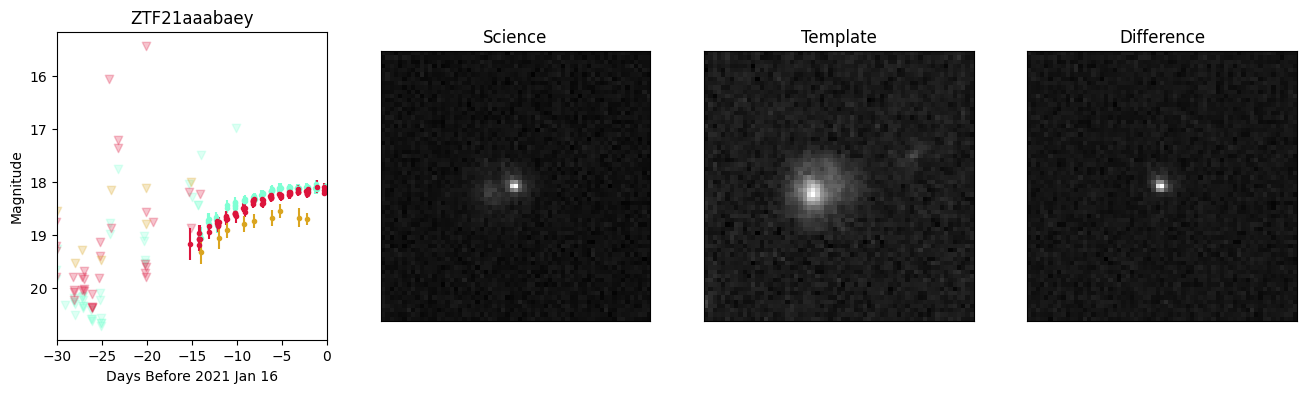

In [52]:
# Let's see the cutouts and light curves for one of the 68 objects that passed our criteria.
show_all(transient_alerts[np.where(objectIds=='ZTF21aaabaey')[0][0]])

This transient (ZTF21aaabaey) was ultimately spectroscopically classified as a Type Ia supernova: https://www.wis-tns.org/object/2021F . You can see its host galaxy in the reference ("template") image.

Type Ia supernovae are the most common types of transients detected in flux-limited surveys. That's because they are both intrinsically quite common, and also quite luminous. Their light curve is powered by the radioactive decay of nickel 56. The half life of nickel 56 is ~1 week, which sets the timescale of the light curve.

### Exercise 3: The variety of light curves

In [53]:
dflc

,jd,fid,pid,diffmaglim,pdiffimfilename,programpi,programid,candid,isdiffpos,tblid,...,zpmed,clrmed,clrrms,neargaia,neargaiabright,maggaia,maggaiabright,exptime,drb,drbversion
0,2.459231e+06,2,1476452595515,20.353445,ztf_20210116452593_000858_zr_c14_o_q4_scimrefd...,Kulkarni,2,1476452595515015000,t,0.0,...,26.306,0.607,0.293496,0.737929,-999.0,16.860332,-999.0,30.0,0.999716,d6_m7
1,2.459201e+06,1,1446457665515,18.728100,/ztf/archive/sci/2020/1217/457431/ztf_20201217...,Kulkarni,2,1476452595515015000,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.459202e+06,2,1447431065515,19.929100,/ztf/archive/sci/2020/1218/430822/ztf_20201218...,Kulkarni,1,1476452595515015000,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.459203e+06,1,1448232815515,19.908199,/ztf/archive/sci/2020/1219/232639/ztf_20201219...,Kulkarni,2,1476452595515015000,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.459203e+06,2,1448277655515,19.842100,/ztf/archive/sci/2020/1219/277650/ztf_20201219...,Kulkarni,2,1476452595515015000,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,2.459230e+06,1,1475305855515,19.634899,/ztf/archive/sci/2021/0115/305845/ztf_20210115...,Kulkarni,1,1476452595515015000,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,2.459230e+06,1,1475315175515,19.907301,/ztf/archive/sci/2021/0115/315093/ztf_20210115...,Kulkarni,2,1476452595515015000,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128,2.459230e+06,1,1475342696115,19.632299,/ztf/archive/sci/2021/0115/342697/ztf_20210115...,Kulkarni,1,1476452595515015000,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,2.459231e+06,2,1476237325515,20.412600,/ztf/archive/sci/2021/0116/237326/ztf_20210116...,Kulkarni,2,1476452595515015000,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
dflc.loc[dflc['magpsf'].notnull(), ['magpsf', 'jd', 'jdstarthist']]

,magpsf,jd,jdstarthist
0,19.528131,2.459231e+06,2.458428e+06
8,19.580799,2.459203e+06,NaN
19,18.937599,2.459205e+06,NaN
22,19.443501,2.459206e+06,NaN
67,19.274799,2.459219e+06,NaN
80,19.749500,2.459222e+06,NaN
87,19.484301,2.459223e+06,NaN
89,20.565001,2.459223e+06,NaN
94,19.847700,2.459224e+06,NaN
95,19.713100,2.459224e+06,NaN


In [59]:
# Identify the transient with the longest-duration light curve:
# in other words, the longest time since the first detection.

min_jd = np.inf

for packet in transient_alerts:
    jd = packet['candidate']['jdstarthist']
    if jd < min_jd:
        min_jd = packet['candidate']['jdstarthist']
        longest_transient = packet['objectId']

longest_transient

'ZTF18aaqjcxl'

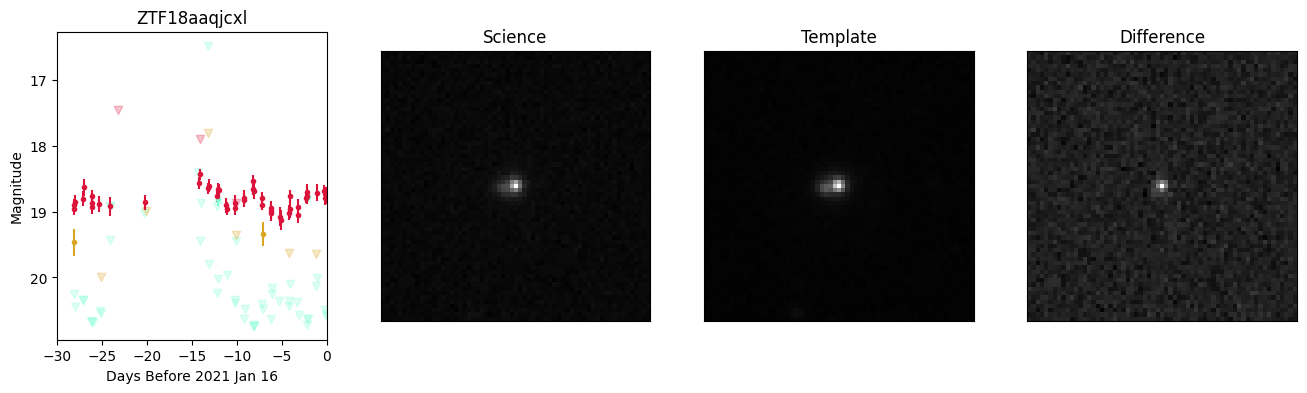

In [60]:
# Let's see the cutouts and light curves for one of the 68 objects that passed our criteria.
show_all(transient_alerts[np.where(objectIds==longest_transient)[0][0]])

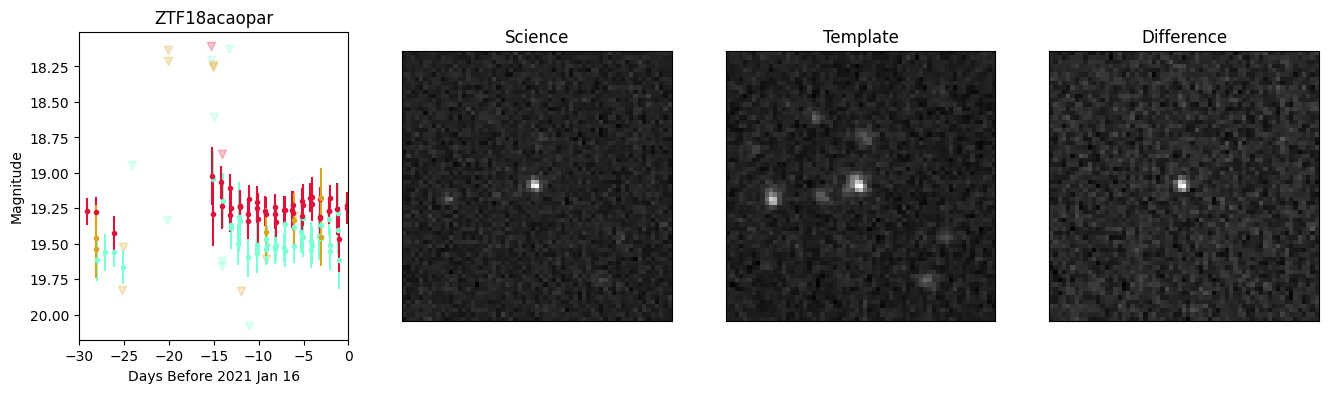

In [63]:
# Identify the transient with the largest number of points in its light curve.

max_ndethist = 0

for packet in transient_alerts:
    ndet = packet['candidate']['ndethist']
    if ndet > max_ndethist:
        max_ndethist = packet['candidate']['ndethist']
        longest_transient = packet['objectId']

longest_transient

show_all(transient_alerts[np.where(objectIds==longest_transient)[0][0]])

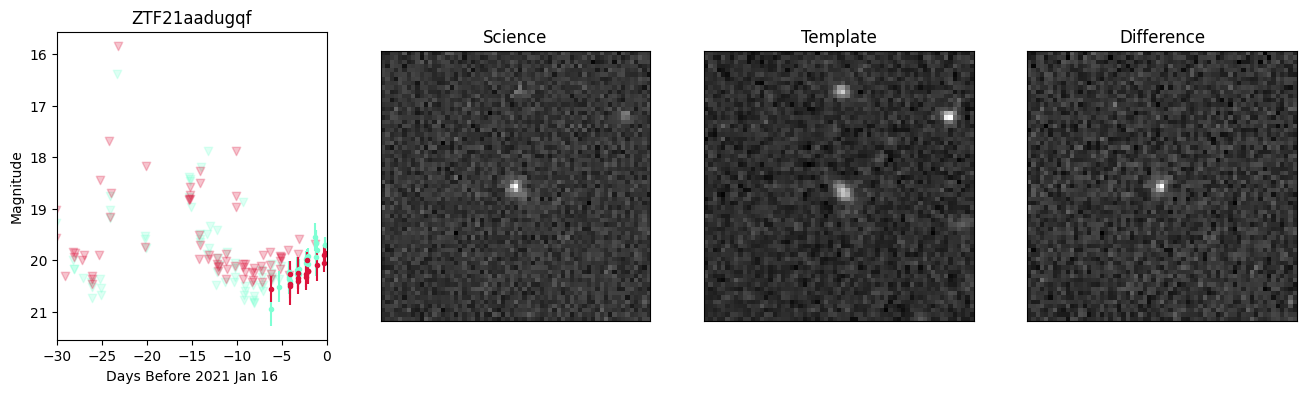

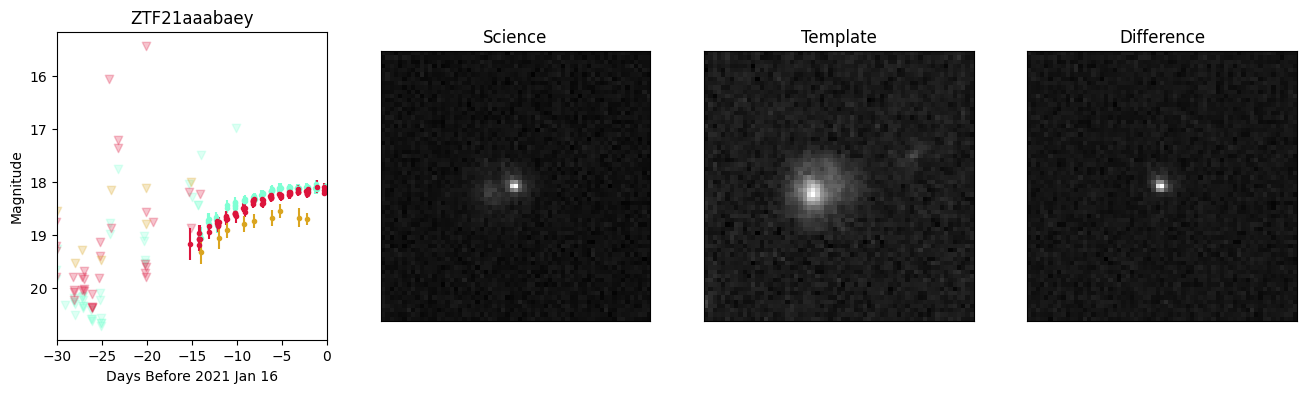

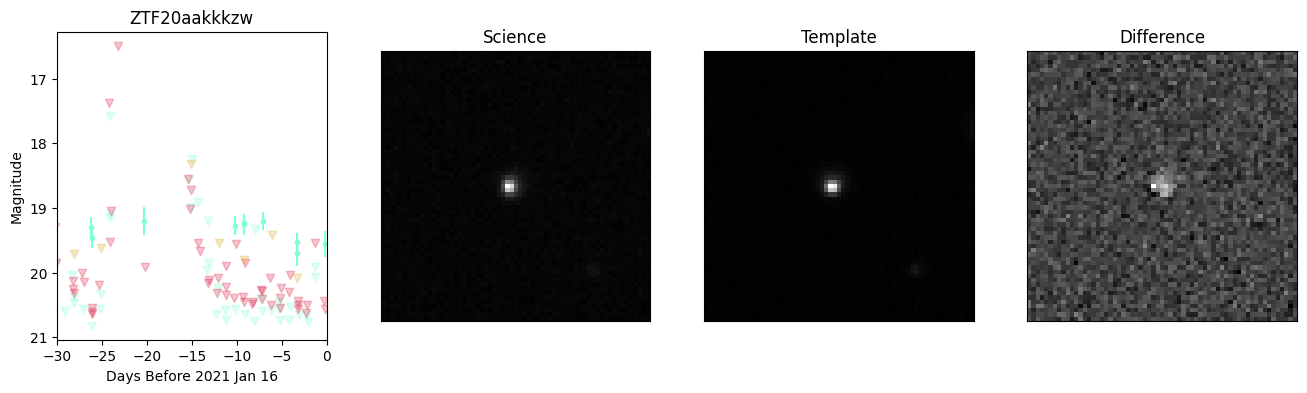

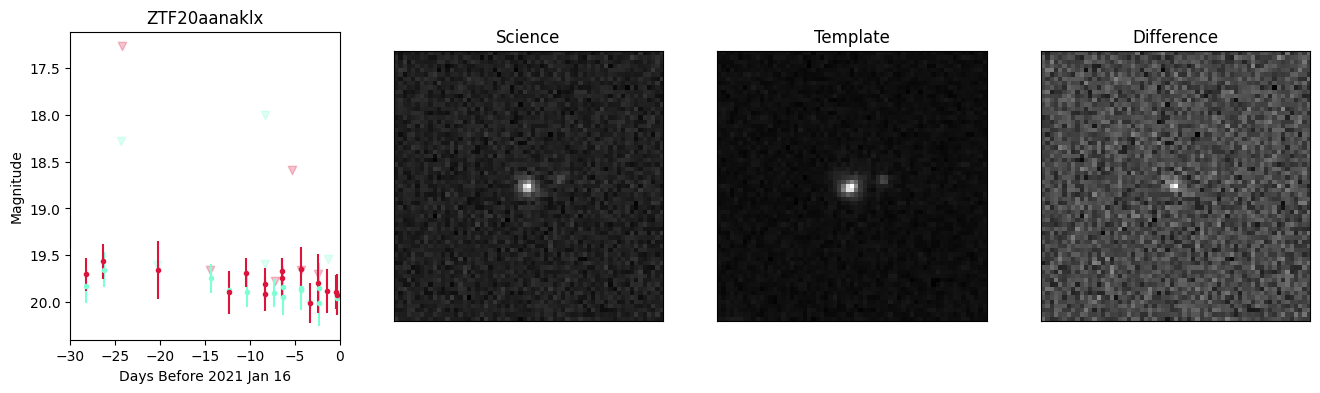

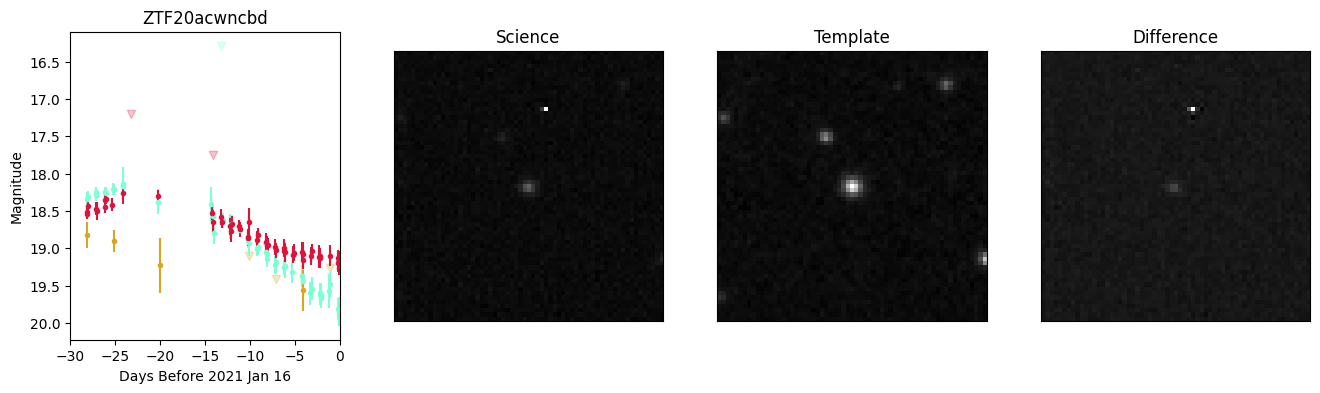

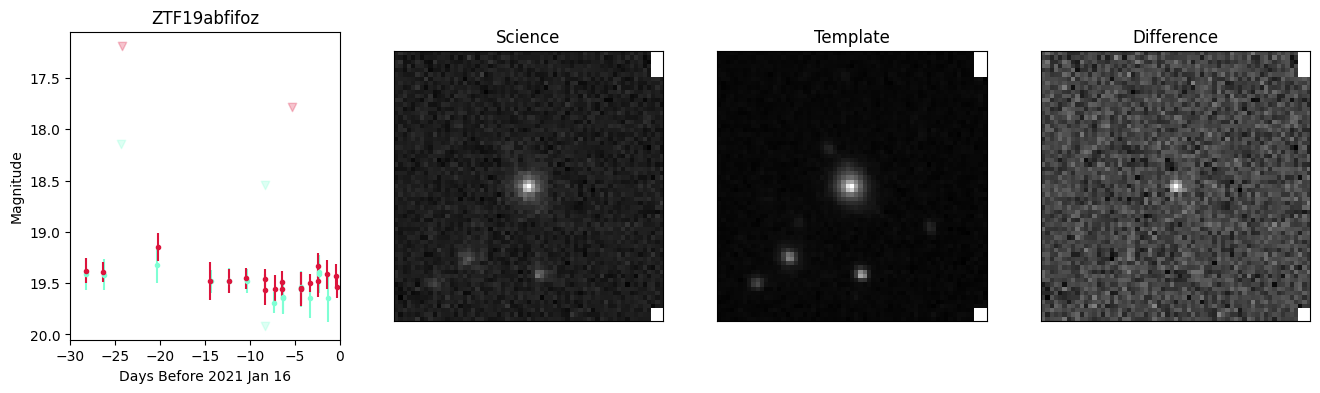

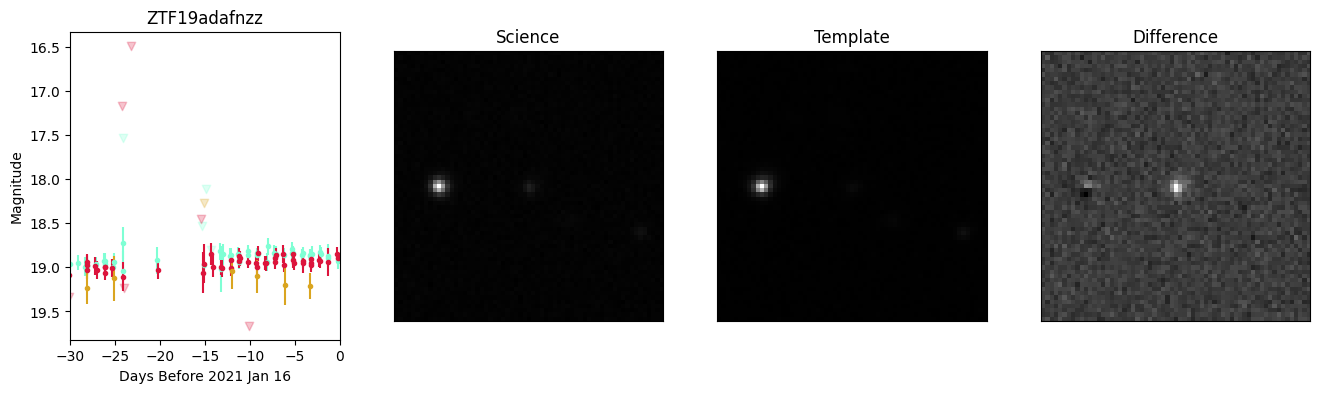

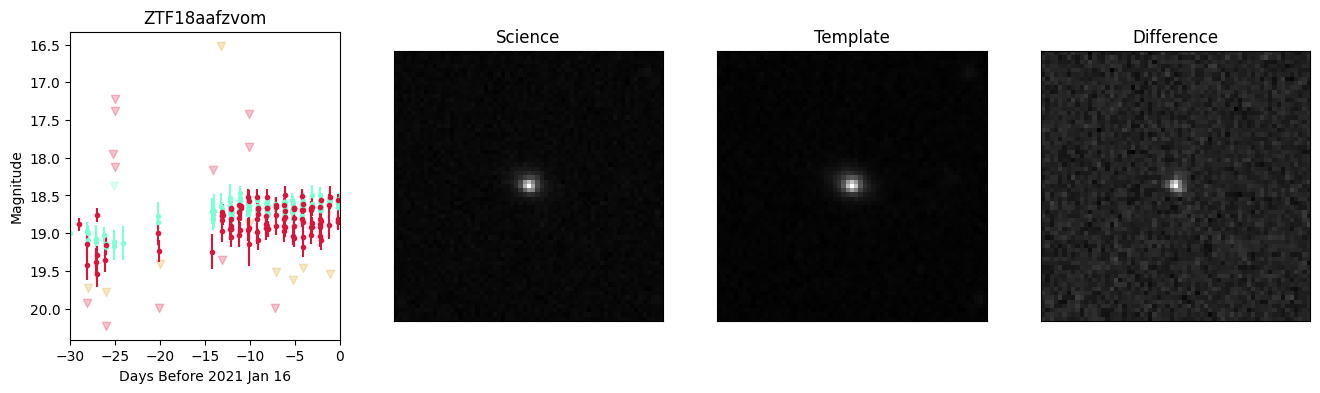

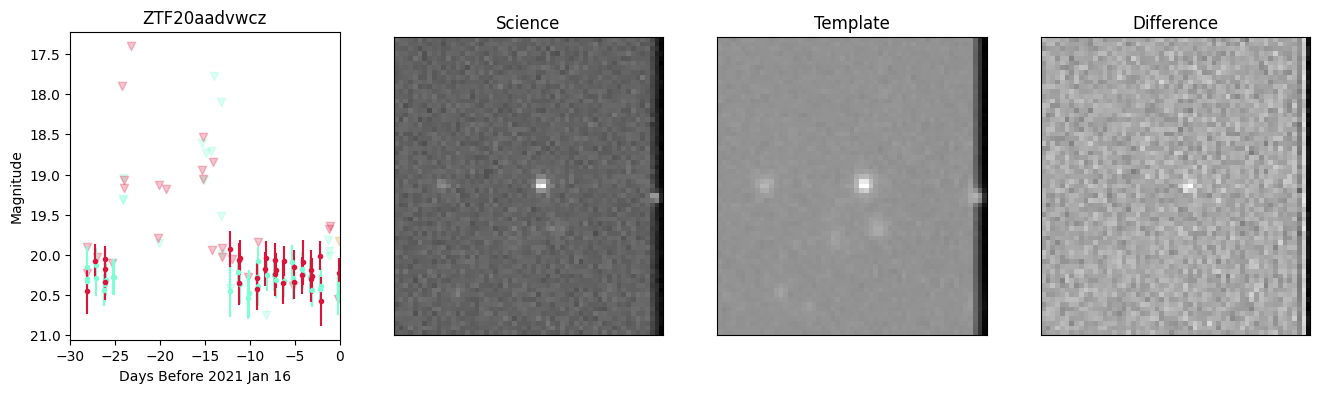

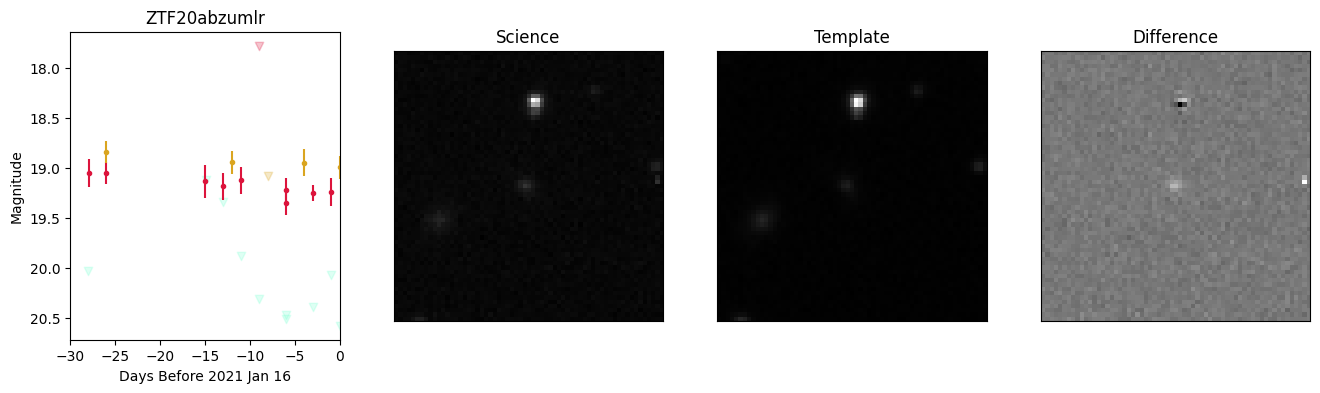

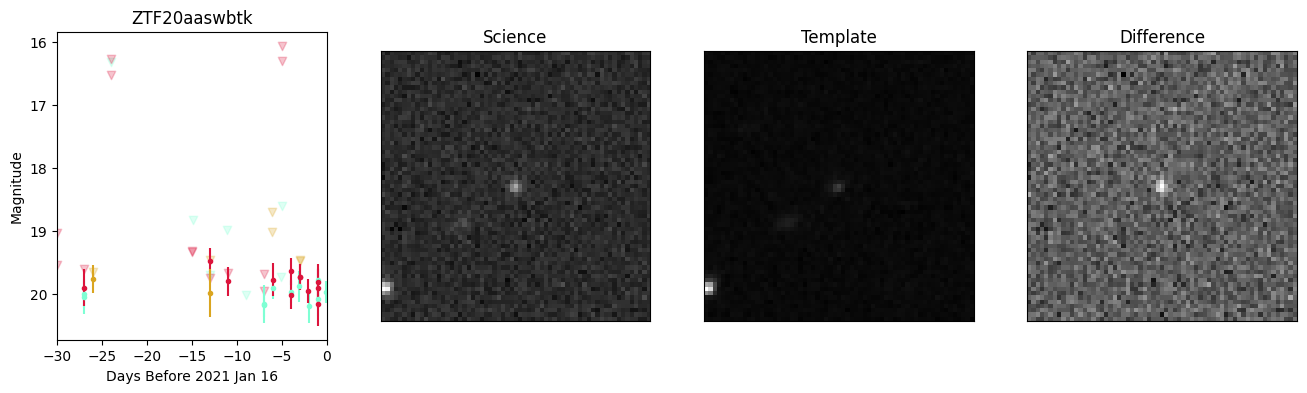

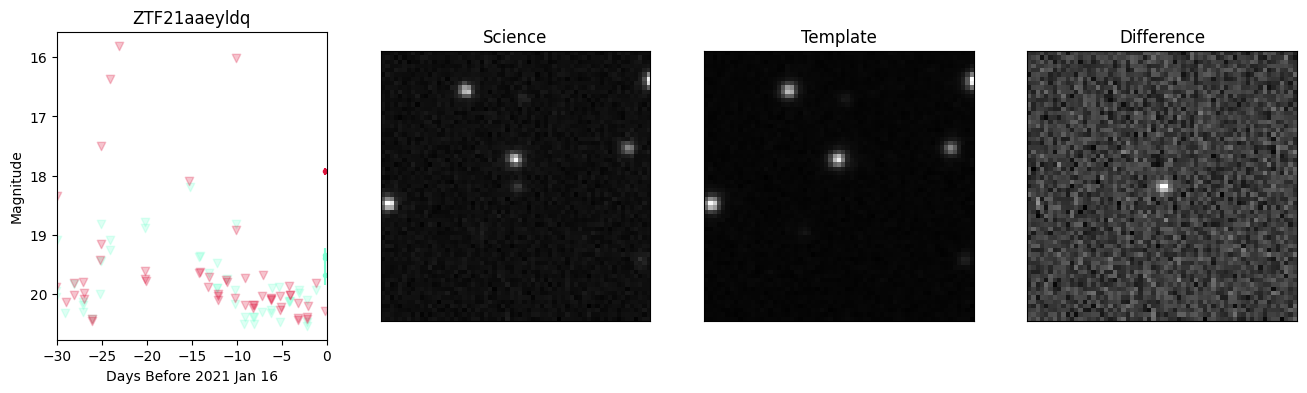

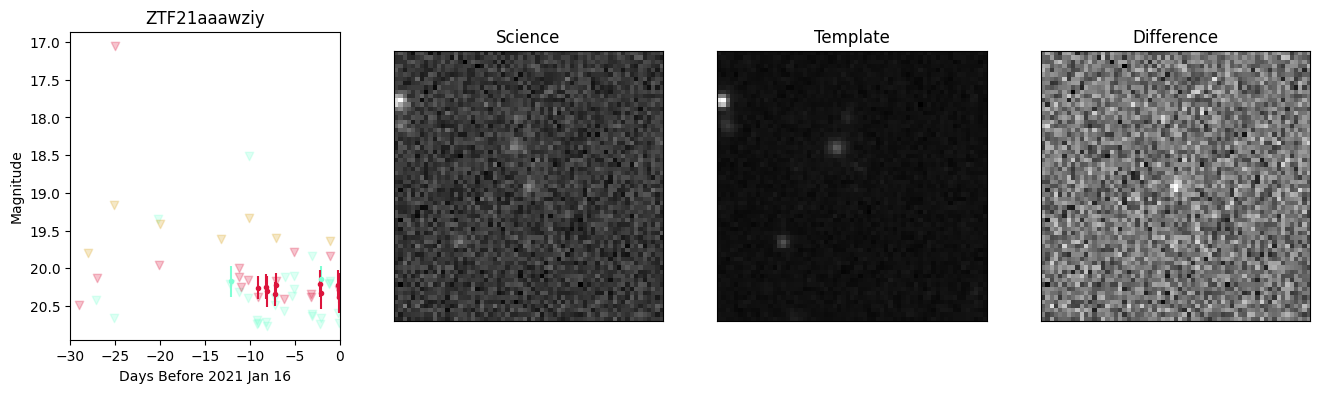

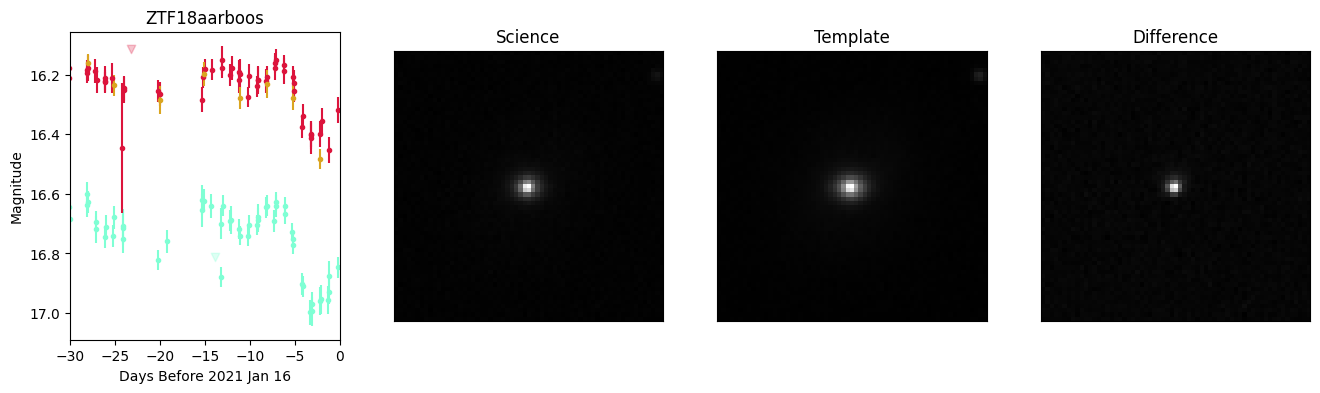

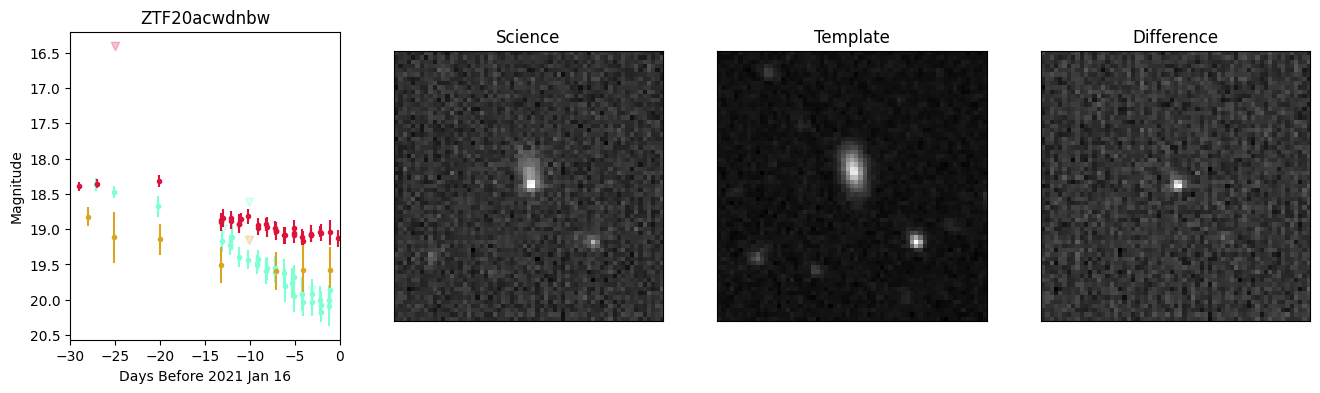

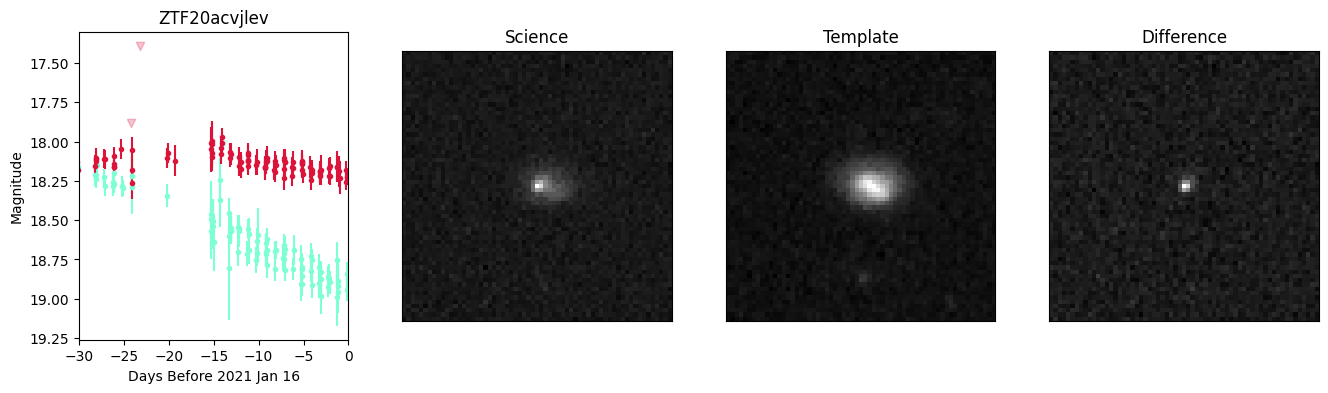

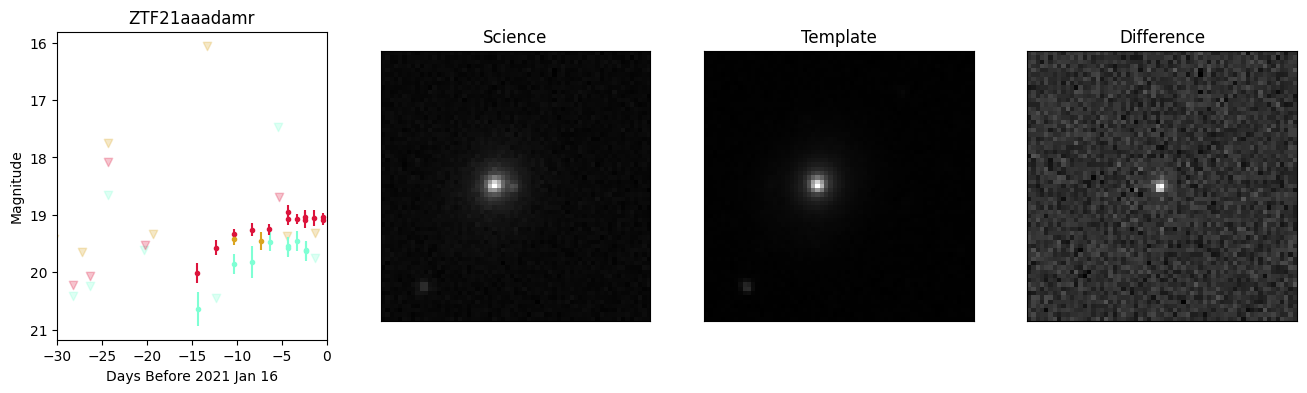

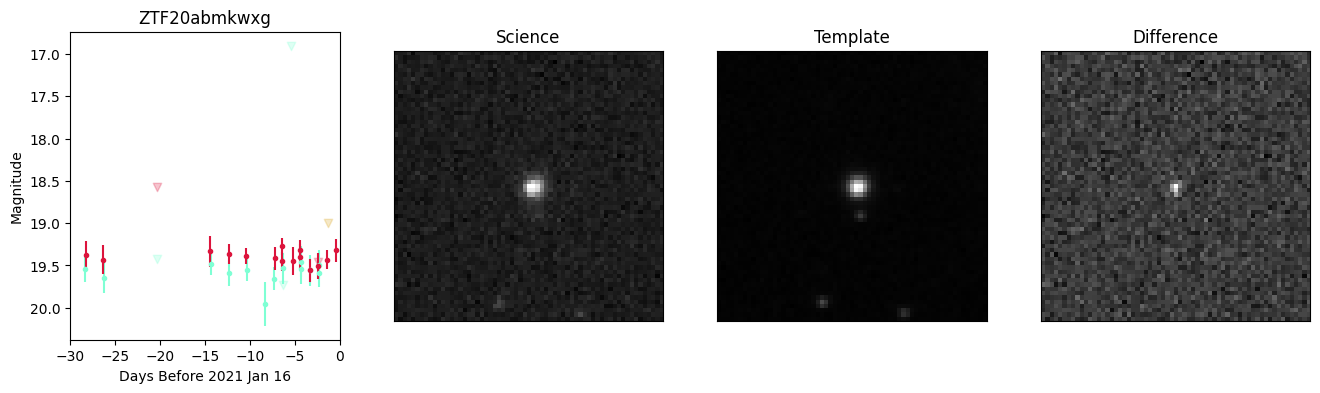

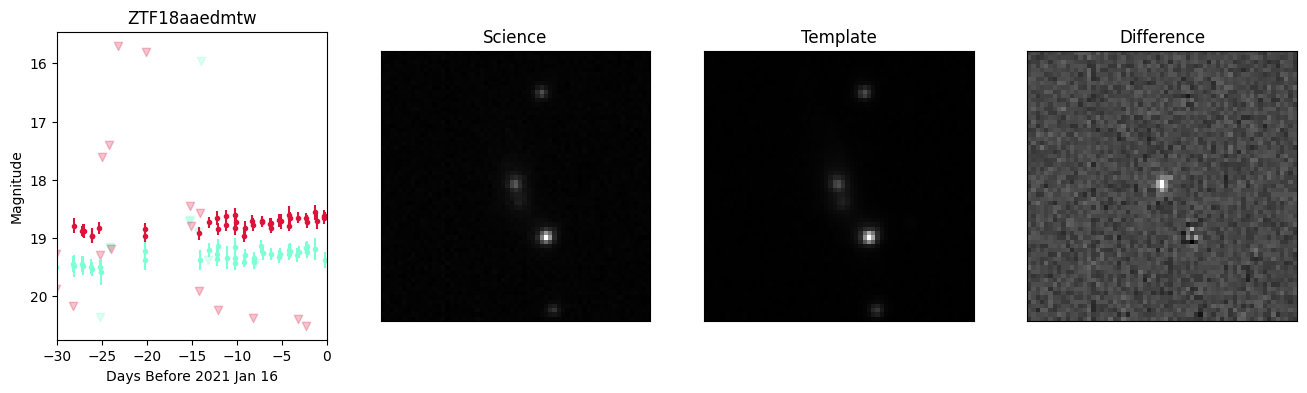

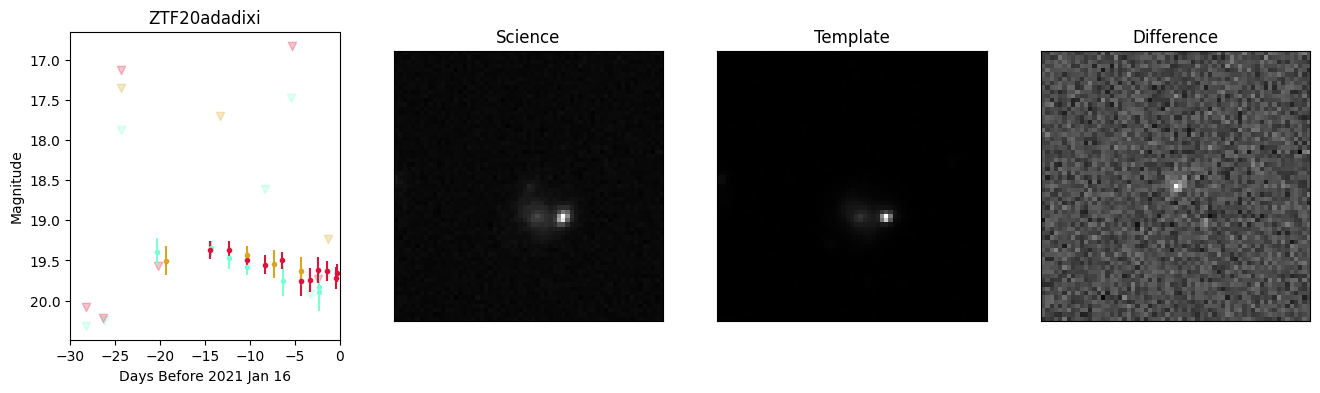

In [64]:
# Plot the light curve of one of the transients you identified above.

# Describe the behavior of its light curve, and speculate about what you think
# it might be. 
# You are welcome to try and find information online about these objects.

for packet in transient_alerts[0:20]:
    show_all(transient_alerts[np.where(objectIds==packet['objectId'])[0][0]])

# Fast transient quest

What is a "fast" transient? Typically, this is defined as a transient whose brightness evolves much more rapidly than a Type Ia supernova. Historically, transient surveys returned to the same location of sky ~once per week, because they were designed to find Type Ia supernovae --- you can see that this would be a reasonable cadence in the light-curve plot above. However, once the cadence of surveys increased to once per day or even once every few hours, we learned that there exist many phenomena with light curves much faster than Type Ia supernova. These fast transients must be powered by different sources of energy.

To find fast transients, it's useful to do two things: (1) measure the rate of change of brightness of the transient's light curve, and (2) focus on transients that are "young" (newly detected that night) to avoid old and/or repeating sources. 

Text(0, 0.5, 'Number of transients')

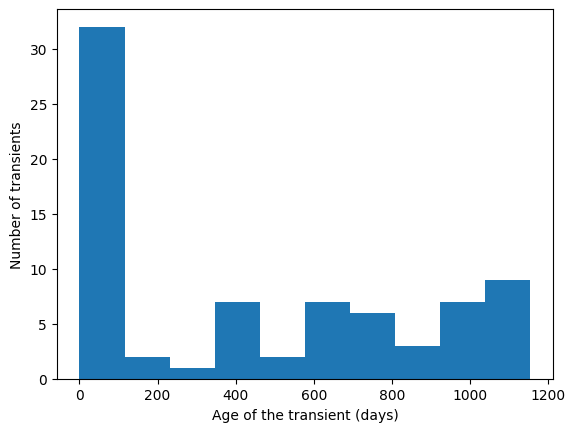

In [65]:
# Select young sources.
jdstart = np.array([alert['candidate']['jdstarthist'] for alert in transient_alerts])
jdnow = np.array([alert['candidate']['jd'] for alert in transient_alerts])
age = jdnow-jdstart
plt.hist(age)
plt.xlabel("Age of the transient (days)")
plt.ylabel("Number of transients")

You can see that some of our transients are hundreds of days old. These are unlikely to be fast transients: they are probably burbling variable sources like AGN.

Let's focus on transients that were detected for the first time on this night, i.e., are less than a day old.

In [66]:
filter_on_age = age<1
young_transients = np.array(transient_alerts)[filter_on_age]
len(young_transients)
objectIds[filter_on_age]

array(['ZTF21aaeyldq', 'ZTF21aaeyldq', 'ZTF21aaeyldq'], dtype='<U12')

Above, you can see that when you apply a filter requiring the transient to be very young --- less than 1 day old --- only one object is left. That object generated 3 alerts that night. Let's take a look at the last alert generated and see what the light curve looks like. We'll have to Zoom in a lot more than we did for the Type Ia supernova...

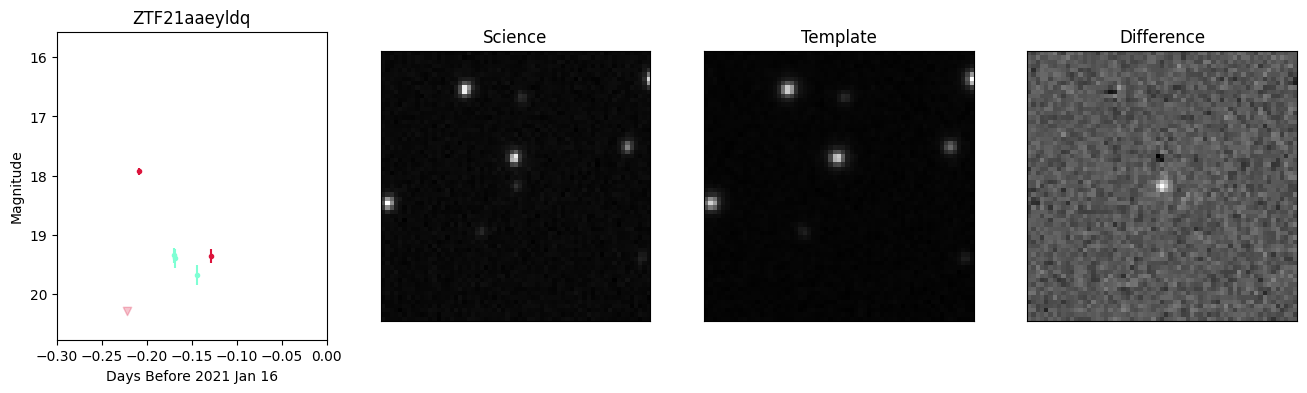

In [67]:
show_all(transient_alerts[np.where(objectIds=='ZTF21aaeyldq')[0][2]], xlim=-0.3)

This transient faded by over a magnitude within a single night! That is VERY fast. Fast transient filters in the literature vary, but definitions of "fast" include 0.3 mag/day ([Andreoni & Couglin et al., 2021](https://ui.adsabs.harvard.edu/abs/2021ApJ...918...63A/abstract)) --- clearly, this is a very fast transient.

Follow-up observations of this transient revealed luminous radio and X-ray emission, and a spectroscopic redshift of z=2.5. Its properties are most similar to GRB afterglows, but no prompt burst of gamma-rays was detected. For more information on this source, see the following papers,<br>
[Ho et al. 2022](https://arxiv.org/abs/2201.12366)<br>
[Gupta et al. 2022](https://arxiv.org/abs/2111.11795)<br>
[Xu et al. 2023](https://ui.adsabs.harvard.edu/abs/2023A%26A...679A.103X/abstract)<br>
[Li et al. 2025](https://arxiv.org/abs/2411.07973v1)

### Exercise 4

In [91]:
# Calculate the exact fade rate of ZTF21aaeyldq:
# the dmag/dt in r-band. 

dflc = make_dataframe(transient_alerts[np.where(objectIds=='ZTF21aaeyldq')[0][2]])
dflc

,jd,fid,pid,diffmaglim,pdiffimfilename,programpi,programid,candid,isdiffpos,tblid,...,zpmed,clrmed,clrrms,neargaia,neargaiabright,maggaia,maggaiabright,exptime,drb,drbversion
0,2.459231e+06,2,1476371194715,20.412451,ztf_20210116371088_001407_zr_c12_o_q4_scimrefd...,Kulkarni,2,1476371194715015012,t,12.0,...,26.389999,0.524,0.216528,6.607444,-999.0,17.335522,-999.0,30.0,0.999883,d6_m7
1,2.459201e+06,2,1446380420215,19.874100,/ztf/archive/sci/2020/1217/380417/ztf_20201217...,Kulkarni,2,1476371194715015012,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.459201e+06,1,1446412090215,19.952801,/ztf/archive/sci/2020/1217/412014/ztf_20201217...,Kulkarni,2,1476371194715015012,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.459201e+06,1,1446413500215,20.054600,/ztf/archive/sci/2020/1217/413507/ztf_20201217...,Kulkarni,1,1476371194715015012,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.459201e+06,1,1446496580215,19.085699,/ztf/archive/sci/2020/1217/496574/ztf_20201217...,Kulkarni,2,1476371194715015012,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,2.459231e+06,2,1476277460215,20.276899,/ztf/archive/sci/2021/0116/277454/ztf_20210116...,Kulkarni,1,1476371194715015012,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,2.459231e+06,2,1476291590215,20.253500,/ztf/archive/sci/2021/0116/291586/ztf_20210116...,Kulkarni,2,1476371194715015012,1,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,2.459231e+06,1,1476330680215,20.444500,/ztf/archive/sci/2021/0116/330671/ztf_20210116...,Kulkarni,1,1476371194715015012,1,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,2.459231e+06,1,1476331620215,20.113300,/ztf/archive/sci/2021/0116/331620/ztf_20210116...,Kulkarni,2,1476371194715015012,1,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
dflc.sort_values('jd', inplace=True)
r_magpsf = dflc.loc[(~dflc['magpsf'].isna()) & (dflc['fid'] == 2), 'magpsf'].to_list()
r_mjd = dflc.loc[(~dflc['magpsf'].isna()) & (dflc['fid'] == 2), 'jd'].to_list()

In [103]:
r_magpsf, r_mjd

([17.9242000579834, 19.358001708984375], [2459230.7915972, 2459230.8711921])

In [105]:
r_magpsf[1] - r_magpsf[0]

1.4338016510009766

In [106]:
r_mjd[1] - r_mjd[0]

0.07959489990025759

In [101]:
(r_magpsf[1] - r_magpsf[0]) / (r_mjd[1] - r_mjd[0])

18.013737724373172

In [248]:
with open("bonus_exercise/fast_transient_alerts.json", 'r') as f:
    fast_alerts = json.load(f)
    
with open("bonus_exercise/fast_transient_lc.json", 'r') as f:
    fast_lcs = json.load(f)

In [249]:
alerts = pd.DataFrame(fast_alerts.values())

In [250]:
def plot_lightcurve(dflc, ax=None, days_ago=True, xlim=-30):
    
    filter_color = {'g': 'mediumaquamarine', 'r': 'Crimson', 'i': 'Goldenrod'} # g-band, r-band, i-band

    if ax is None:
        plt.figure()
    for filt, color in filter_color.items():
        # plot detections in this filter:
        w = (dflc.filter == filt) & ~dflc.magpsf.isnull()
        jd = dflc.loc[dflc['filter'] == filt, 'jd'].values
        mag = dflc.loc[dflc['filter'] == filt, 'magpsf'].values
        sigmapsf = dflc.loc[dflc['filter'] == filt, 'sigmapsf'].values
        
        plt.errorbar(jd, mag, sigmapsf, fmt='.', color=color)
        # wnodet = (dflc.filter == filt) & dflc.magpsf.isnull()
        # if np.sum(wnodet):
        #     plt.scatter(t[wnodet],dflc.loc[wnodet,'diffmaglim'], marker='v',color=color,alpha=0.25)
    
    # plt.xlim(xlim, 0)
    plt.gca().invert_yaxis()
    # plt.xlabel(xlabel)
    plt.ylabel('Magnitude')
    # plt.title(dflc.objectId)
    
def make_dflc(ztfid, lcs):
    df = pd.DataFrame(lcs[ztfid])
    df['objectId'] = ztfid
    return df

In [251]:
dflc = make_dflc('ZTF18aacgqfy', fast_lcs)
# dflc

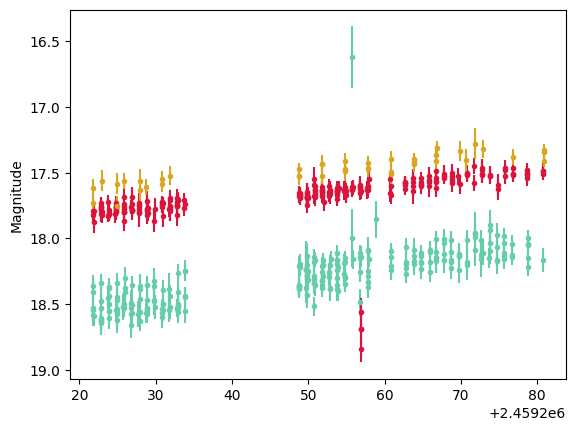

In [252]:
plot_lightcurve(dflc)

In [253]:
g_lc = dflc.loc[dflc['filter'] == 'g'].reset_index(drop=True)
r_lc = dflc.loc[dflc['filter'] == 'r'].reset_index(drop=True)

g_decline_rates = [
    (g_lc.iloc[i+1]['magpsf'] - g_lc.iloc[i]['magpsf']) / 
    (g_lc.iloc[i+1]['jd'] - g_lc.iloc[i]['jd'])
    for i in range(len(g_lc) - 1)
]

r_decline_rates = [
    (r_lc.iloc[i+1]['magpsf'] - r_lc.iloc[i]['magpsf']) / 
    (r_lc.iloc[i+1]['jd'] - r_lc.iloc[i]['jd'])
    for i in range(len(r_lc) - 1)
]

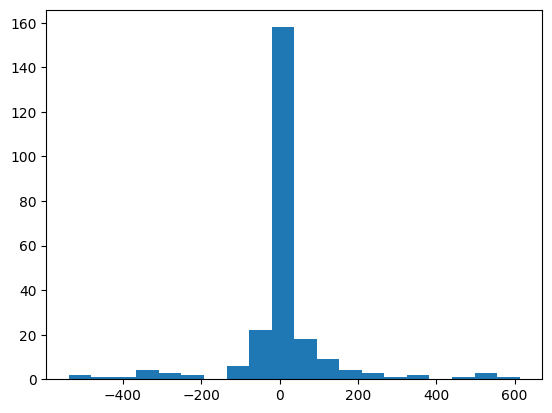

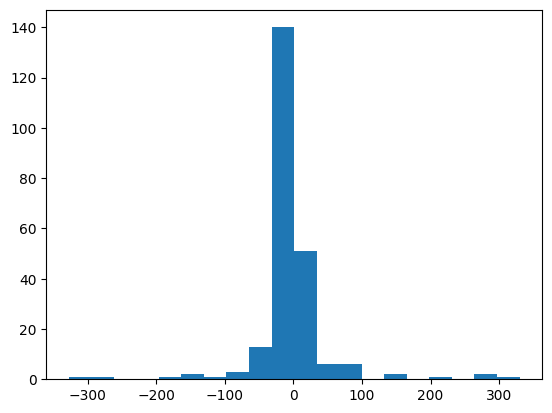

In [254]:
plt.hist(g_decline_rates, bins=20)
plt.show()

plt.hist(r_decline_rates, bins=20)
plt.show()

In [247]:
# list(alerts)

In [256]:
alerts['age'] = alerts['jd'] - alerts['jdstarthist']

alerts['ps_good'] = np.logical_and(
    (alerts['distpsnr1'].isnull()) | (alerts['distpsnr1'] > 1.5), 
    alerts['sgscore1'] < 0.5
)


In [ ]:

cand = alerts.loc[
    (alerts['ssdistnr'] < 0) &
    (alerts['age'] < 2) &
    (alerts['age'] > 30 / 60 / 24) &
    # (alerts['ndethist'] < 8) &
    (alerts['ps_good'])
]

len(cand)

85

In [259]:
long_lcs = []
for objid in cand['objectId'].unique():
    
    dflc = make_dflc(objid, fast_lcs)
    # print(objid, len(dflc))
    if len(dflc) > 8:
        # print(objid, len(dflc))
        long_lcs.append(objid)


In [260]:
cand = cand[~cand['objectId'].isin(long_lcs)].reset_index(drop=True)
len(cand)

12

In [261]:
# plt.hist(alerts['ndethist'], bins=20)
# plt.hist(cand['ndethist'], bins=20)

In [262]:
cand['objectId'].unique()

array(['ZTF21aagwbjr', 'ZTF21aahbfyn', 'ZTF21aagobok', 'ZTF21aagshio',
       'ZTF21aagkkaa', 'ZTF21aahdrpt', 'ZTF21aagtmos'], dtype=object)

ZTF21aagwbjr


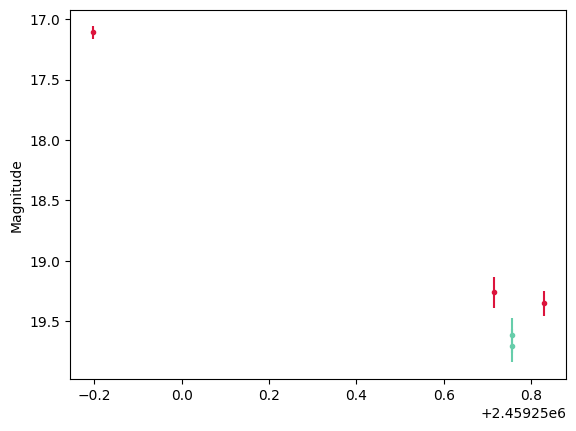

ZTF21aahbfyn


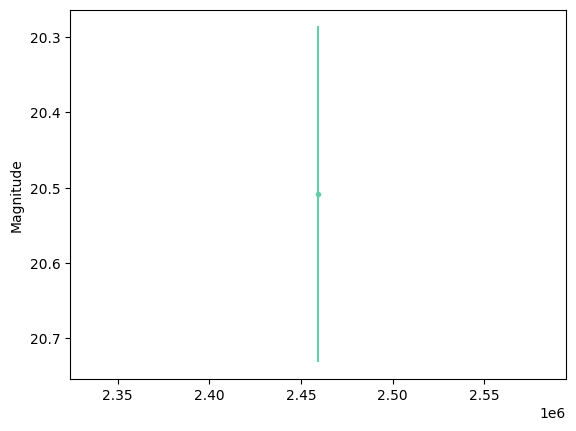

ZTF21aagobok


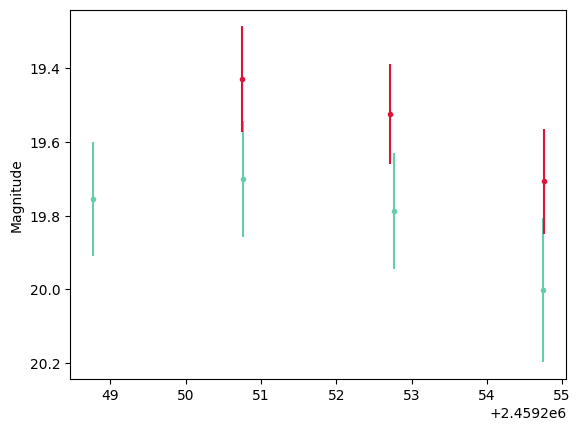

ZTF21aagshio


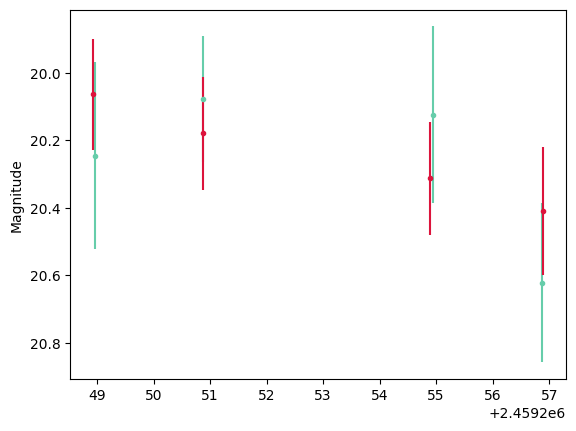

ZTF21aagkkaa


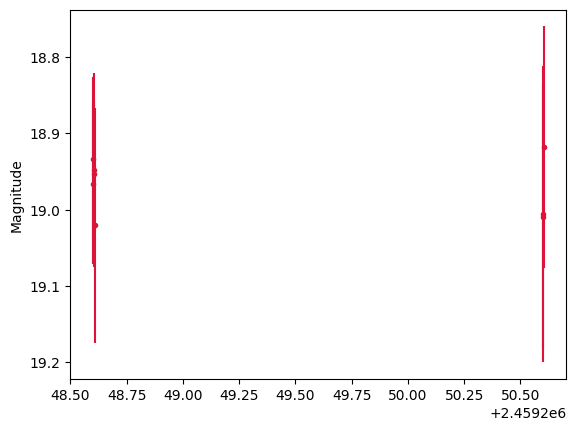

ZTF21aahdrpt


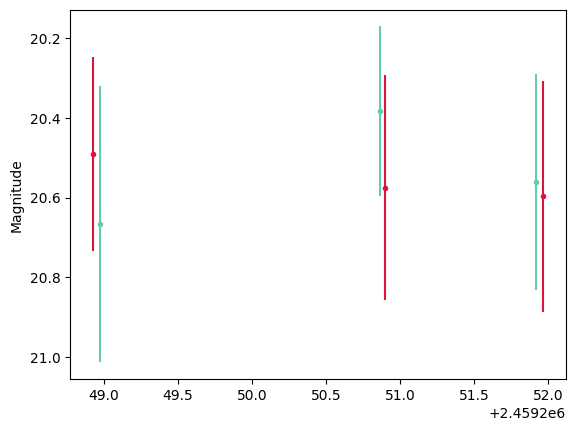

ZTF21aagtmos


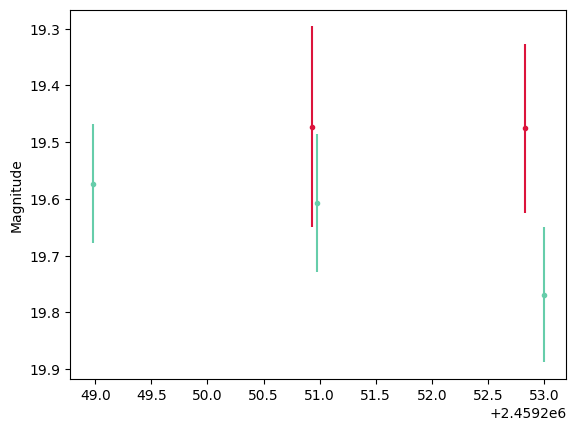

In [263]:
for objid in cand['objectId'].unique():
    print(objid)
    plot_lightcurve(make_dflc(objid, fast_lcs), xlim=-30)
    plt.show()